## Осипов Сергей Владимирович
# Анализ данных в индустрии. Проект 1

In [62]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

def connect_and_query_greenplum(host, dbname, user, password, port, query):
    connection = psycopg2.connect(
        host=host,
        dbname=dbname,
        user=user,
        password=password,
        port=port
    )

    cursor = connection.cursor()
    cursor.execute(query)

    columns = [desc[0] for desc in cursor.description]
    data = cursor.fetchall()

    cursor.close()
    connection.close()

    df = pd.DataFrame(data, columns=columns)
    return df

def plot_graph_week(dataframe):
    fig, ax1 = plt.subplots()

    ax1.plot(dataframe["week_number"], dataframe["count_client_rk"], label="Количество клиентов", color="blue")
    ax1.set_xlabel("Номер недели")
    ax1.set_ylabel("Количество клиентов")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()

    ax2.plot(dataframe["week_number"], dataframe["percent_registered"], label="Конверсия (Зарегистрировано)", color="red")
    ax2.plot(dataframe["week_number"], dataframe["percent_submitted_an_application_for_the_game"], label="Конверсия (Подано заявок)", color="green")
    ax2.plot(dataframe["week_number"], dataframe["percent_participated_in_the_game"], label="Конверсия (Участвовало в игре)", color="orange")
    ax2.set_ylabel("Конверсия, %")
    ax2.tick_params(axis='y', labelcolor="black")

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="best")

    plt.title("Количество клиентов и конверсии")
    plt.show()

def plot_graph_month(dataframe):
    fig, ax1 = plt.subplots()

    ax1.plot(dataframe["month_number"], dataframe["count_client_rk"], label="Количество клиентов", color="blue")
    ax1.set_xlabel("Номер месяца")
    ax1.set_ylabel("Количество клиентов")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()

    ax2.plot(dataframe["month_number"], dataframe["percent_registered"], label="Конверсия (Зарегистрировано)", color="red")
    ax2.plot(dataframe["month_number"], dataframe["percent_submitted_an_application_for_the_game"], label="Конверсия (Подано заявок)", color="green")
    ax2.plot(dataframe["month_number"], dataframe["percent_participated_in_the_game"], label="Конверсия (Участвовало в игре)", color="orange")
    ax2.set_ylabel("Конверсия, %")
    ax2.tick_params(axis='y', labelcolor="black")

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="best")

    plt.title("Количество клиентов и конверсии")
    plt.show()

host = '158.160.52.106'
dbname = 'postgres'
user = 'student'
password = 'JvLda93aA'
port = '5432'

## Воронка: динамика по неделям

In [63]:
query = """
SELECT week_number,
       COUNT(client_rk) AS count_client_rk,
       SUM(registered) AS count_registered,
       ROUND(SUM(registered)::decimal / COUNT(client_rk) * 100, 3) AS percent_registered,
       SUM(submitted_an_application_for_the_game) AS count_submitted_an_application_for_the_game,
       ROUND(SUM(submitted_an_application_for_the_game)::decimal / COUNT(client_rk) * 100, 3) AS percent_submitted_an_application_for_the_game,
       SUM(participated_in_the_game) AS count_participated_in_the_game,
       ROUND(SUM(participated_in_the_game)::decimal / COUNT(client_rk) * 100, 3) AS percent_participated_in_the_game
FROM (
    SELECT 
           CASE 
               WHEN year > 2022 AND week_number <> 52 THEN week_number + 52
               ELSE week_number
           END week_number,
           client_rk,
           CASE 
               WHEN client_rk IN (SELECT client_rk FROM msu_analytics.account) THEN 1
               ELSE 0
           END AS registered,
           CASE
               WHEN client_rk IN (SELECT client_rk FROM msu_analytics.account WHERE account_rk IN (SELECT account_rk FROM msu_analytics.application)) THEN 1
               ELSE 0
           END AS submitted_an_application_for_the_game,
           CASE
               WHEN client_rk IN (SELECT client_rk FROM msu_analytics.account WHERE account_rk IN (SELECT account_rk FROM msu_analytics.application 
               WHERE game_rk IN (SELECT game_rk FROM msu_analytics.game WHERE game_flg = 1))) THEN 1
               ELSE 0
           END AS participated_in_the_game
    FROM (
        SELECT client_rk,
               DATE_PART('week', visit_dttm) AS week_number,
               DATE_PART('year', visit_dttm) AS year
        FROM msu_analytics.client
    ) t3
) t6
GROUP BY week_number
ORDER BY week_number;
"""

dataframe_week = connect_and_query_greenplum(host, dbname, user, password, port, query)
dataframe_week.head(5)

,week_number,count_client_rk,count_registered,percent_registered,count_submitted_an_application_for_the_game,percent_submitted_an_application_for_the_game,count_participated_in_the_game,percent_participated_in_the_game
0,35.0,111,32,28.829,7,6.306,5,4.505
1,36.0,184,31,16.848,6,3.261,5,2.717
2,37.0,167,43,25.749,16,9.581,8,4.790
3,38.0,181,45,24.862,12,6.630,11,6.077
4,39.0,195,59,30.256,17,8.718,17,8.718


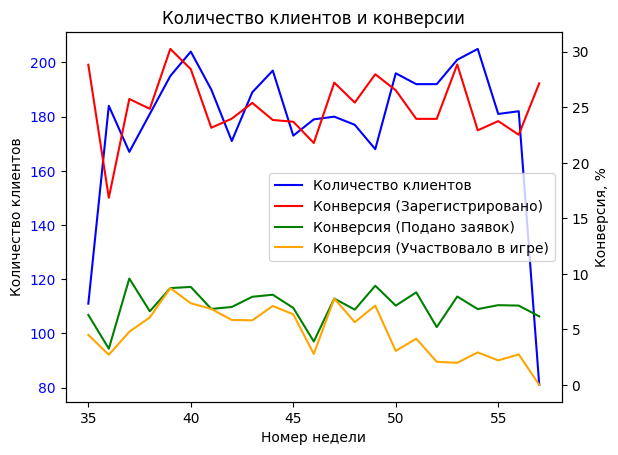

In [64]:
plot_graph_week(dataframe_week)


## Воронка: динамика по месяцам

In [65]:
query = """
SELECT month_number,
       COUNT(client_rk) AS count_client_rk,
       SUM(registered) AS count_registered,
       ROUND(SUM(registered)::decimal / COUNT(client_rk) * 100, 3) AS percent_registered,
       SUM(submitted_an_application_for_the_game) AS count_submitted_an_application_for_the_game,
       ROUND(SUM(submitted_an_application_for_the_game)::decimal / COUNT(client_rk) * 100, 3) AS percent_submitted_an_application_for_the_game,
       SUM(participated_in_the_game) AS count_participated_in_the_game,
       ROUND(SUM(participated_in_the_game)::decimal / COUNT(client_rk) * 100, 3) AS percent_participated_in_the_game
FROM (
    SELECT 
           CASE 
               WHEN year > 2022 THEN month_number + 12
               ELSE month_number
           END month_number,
           client_rk,
           CASE 
               WHEN client_rk IN (SELECT client_rk FROM msu_analytics.account) THEN 1
               ELSE 0
           END AS registered,
           CASE
               WHEN client_rk IN (SELECT client_rk FROM msu_analytics.account WHERE account_rk IN (SELECT account_rk FROM msu_analytics.application)) THEN 1
               ELSE 0
           END AS submitted_an_application_for_the_game,
           CASE
               WHEN client_rk IN (SELECT client_rk FROM msu_analytics.account WHERE account_rk IN (SELECT account_rk FROM msu_analytics.application 
               WHERE game_rk IN (SELECT game_rk FROM msu_analytics.game WHERE game_flg = 1))) THEN 1
               ELSE 0
           END AS participated_in_the_game
    FROM (
        SELECT client_rk,
               DATE_PART('month', visit_dttm) AS month_number,
               DATE_PART('year', visit_dttm) AS year
        FROM msu_analytics.client
    ) t3
) t6
GROUP BY month_number
ORDER BY month_number;
"""

dataframe_month = connect_and_query_greenplum(host, dbname, user, password, port, query)
dataframe_month.head(5)

,month_number,count_client_rk,count_registered,percent_registered,count_submitted_an_application_for_the_game,percent_submitted_an_application_for_the_game,count_participated_in_the_game,percent_participated_in_the_game
0,9.0,778,190,24.422,51,6.555,39,5.013
1,10.0,843,217,25.741,65,7.711,56,6.643
2,11.0,786,200,25.445,56,7.125,50,6.361
3,12.0,805,196,24.348,57,7.081,33,4.099
4,13.0,852,213,25.000,64,7.512,20,2.347


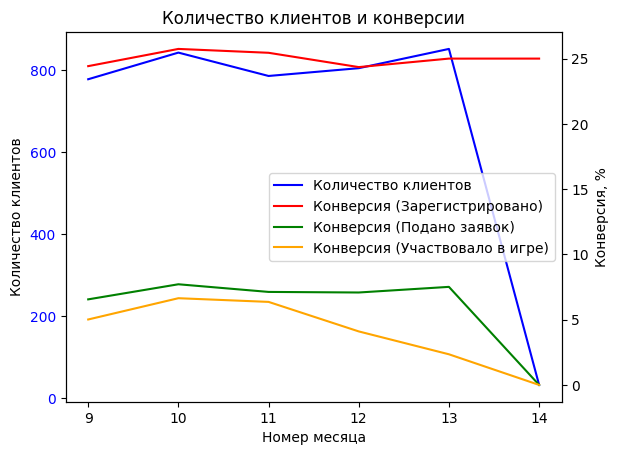

In [66]:
plot_graph_month(dataframe_month)

## Вывод: рост количества новых клиентов в декабре - начале января обусловлен Новогодними праздниками. Следующий рост клиентов прогнозируется во второй половине февраля - начало марта.